# NLP Analysis of FOMC Statement

<p>This analysis has two main steps, one is to carry out the text mining of FOMC statement, the second is to analyze the impact to the market given a FOMC statement<p/>
<p>First part is aimed to do sentimental analysis (using NRC/Vader/Hu&Liu Lexicon), topic analysis (LDA) and text summarization regarding the FOMC statement, applying different approaches to have a in-depth understanding about FOMC statement.</p>
<li> Appliying three mainstream NLP lexicon to analyse the sentimental changes in FOMC statement
<li> Carry out the word frequency statistics and text topic analysis to find the most common words and important sentence (topic sentence given a FOMC statement).
 
<p>Second part is to find out the impact given the FOMC sentimental analysis result, how market reacts to this changes. Basically, the model can be expalined as following, 
    <li>$\sigma _{market} = f(sentimental\ scores\ of\ FOMC\ statement)$</li>
Here I use logistic regression with Cross validation model, SVM model and random forest model to train our model</p> 
<li> For logistic regression with CV using NRC Negative Score,it has 64% percision to verify whether the volatility of 10yr T-note goes up or down</li>
<li> For SVM model, it only as 50% percision, which is not good but theoretically speaking, it should be better than random forest classfier.</li>
<li> For randorm forest, it has 55% percision. But it may cause overfitting regarding the FOMC data points is kind of small.</li>

<p>There are lots of improvements and works that we have to do in the the following future:
    <li>First, we may need to build our own lexicon towards the FOMC statement, assigning sentimental socres to both word based and sentence based professionally.Also, we need to carry out our dependency features. For example, in sentence 'The Monetary Policy is continuously stricted', it's better to find dependency features for this sentence. Monterary (ADJP) Policy (NP) is (VP) continuously (ADVP) stricted (VP) ---> Policy (NP) stricted (VP) (remove adj and adv) to find the dependency features.</li>
    <li>Second,it's better to incorporate both the implementation notes and statements together into analysis. It requies the amendment to the algo for web scrapping. And extend the analysis time span, for example, from 1990 till now, it help to add more samples to our dataset. The more data points, the better training models will be</li>
    <li>Third, shorten the time frequency is another way to both add more data points and improve the prediction result.Instead focous on daily or weekly influence, for example, we can do analysis on market change on 5min/10min/1h research after the announcement of FOMC and it may revealve the casual causal relationship better bewteern the FOMC statement and market reaction.

In [8]:
import urllib
import re
import requests
from bs4 import BeautifulSoup

## Find all the statement links from 2014-2019

In [164]:
request = requests.get('https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm')

In [165]:
content = BeautifulSoup(request.content,'lxml')

In [167]:
page_link = content.find_all('a')
page_url = list()
for i in page_link:
    page_url.append(i.get('href'))
page_url = str(page_url)

In [145]:
##Use Regex Compile to find the link to statement after inspecting FOMC website
pattern = r'/newsevents/pressreleases/monetary\d{8}[a].htm'
page_link = re.findall(pattern,page_url)

In [146]:
page_result = list()
for i in page_link:
    page_result.append('https://www.federalreserve.gov'+i)

In [147]:
page_result

['https://www.federalreserve.gov/newsevents/pressreleases/monetary20190130a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20180131a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20180321a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20180502a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20180613a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20180801a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20180926a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20181108a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20181219a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20170201a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20170315a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20170503a.htm',
 'https://www.fe

## Get the statement from the url list

In [169]:
def get_FOMC_statement(url):
    request = requests.get(url)
    page_soup = BeautifulSoup(request.content,'lxml')
    content = page_soup.find('div',class_="col-xs-12 col-sm-8 col-md-8").find_all('p')
    text_list = list()
    paragraph = str()
    for text in content:
        text_list.append(text.get_text())
    for i in range(len(text_list)):
        paragraph += text_list[i].replace('\n','').strip()
    return url[-13:-5],paragraph

In [172]:
result = list()
for url in page_result:
    tag,text = get_FOMC_statement(url)
    result.append((tag,text))
## Return the text tuple for our sentimental analysis

In [173]:
result

[('20190130',
  "Information received since the Federal Open Market Committee met in December indicates that the labor market has continued to strengthen and that economic activity has been rising at a solid rate. Job gains have been strong, on average, in recent months, and the unemployment rate has remained low. Household spending has continued to grow strongly, while growth of business fixed investment has moderated from its rapid pace earlier last year. On a 12-month basis, both overall inflation and inflation for items other than food and energy remain near 2 percent. Although market-based measures of inflation compensation have moved lower in recent months, survey-based measures of longer-term inflation expectations are little changed.Consistent with its statutory mandate, the Committee seeks to foster maximum employment and price stability. In support of these goals, the Committee decided to maintain the target range for the federal funds rate at 2-1/4 to 2-1/2 percent. The Comm

## Implement the sentimental analysis regarding the statement

### Approach 1: Using NRC Emotion Lexicon: words coded into emotional categories (Multilingual)
<li>http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm

In [174]:
## Create the data bast for sentimental analysis
def get_nrc_data(multi_language = False):
    emotion_dict=dict()
    if multi_language:
        nrc = nrc = pd.read_csv('NRC-Emotion-Lexicon-v0.92-In105Languages-Nov2017Translations.csv',
                                encoding = "ISO-8859-1")
        for x in range(len(nrc)):
            for y in range(105):
                word = nrc.iloc[x][y]
                if emotion_dict.get(word):
                    for i in ['Positive','Negative','Anger','Anticipation','Disgust',
                              'Fear','Joy','Sadness','Surprise','Trust']:
                        if nrc.iloc[x][i]==1:
                            emotion_dict[word].add(i)
                else:
                    emotion_dict[word] = set(' '.join(
                        list(np.array(['Positive','Negative','Anger','Anticipation',
                                       'Disgust','Fear','Joy','Sadness','Surprise','Trust'])
                             * np.array(nrc.iloc[x][105:]))).split())
    else:
        nrc = "NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
        count=0
        with open(nrc,'r') as f:
            all_lines = list()
            for line in f:
                if count < 46:
                    count+=1
                    continue
                line = line.strip().split('\t')
                if int(line[2]) == 1:
                    if emotion_dict.get(line[0]):
                        emotion_dict[line[0]].append(line[1])
                    else:
                        emotion_dict[line[0]] = [line[1]]
    return emotion_dict

In [176]:
emotion_dict = get_nrc_data()

### Define the emotional analyzer

In [177]:
def emotion_analyzer(text,emotion_dict=emotion_dict):
    #Set up the result dictionary
    emotions = {x for y in emotion_dict.values() for x in y} 
    #list comprehension - 
    #emotion for (emotion_list in emotion_dict.values() for emotion in emotion_list
    emotion_count = dict()
    for emotion in emotions:
        emotion_count[emotion] = 0
    
    def tokenize(sentence):
        import string
        from nltk.tokenize import word_tokenize
    # remove all ASCII punctuations and numbers
        del_estr = string.punctuation + string.digits  
        replace = " "*len(del_estr)
        tran_tab = str.maketrans(del_estr, replace)
        sentence = sentence.translate(tran_tab)  
    
    #word tokenized
        words = word_tokenize(sentence)  
    
    # Construct a list of words after getting rid of unimportant ones and numbers
        from nltk.corpus import stopwords
        lowercase_words = [word.lower() for word in words if word not in stopwords.words() and word.isalpha()]
        return lowercase_words
    #Analyze the text and normalize by total number of words
    total_words = len(text.split())
    for word in tokenize(text):
        if emotion_dict.get(word):
            for emotion in emotion_dict.get(word):
                emotion_count[emotion] += 1/total_words #relative scoring0
    return emotion_count

### Store the result in a dataframe

In [178]:
def comparative_emotion_analyzer(text_tuples,object_name="Date"):
    import pandas as pd
    df = pd.DataFrame(columns=[object_name,'Fear','Trust','Negative',
                           'Positive','Joy','Disgust','Anticipation',
                           'Sadness','Surprise'],)
    df.set_index(object_name,inplace=True)
    
    output = df    
    for text_tuple in text_tuples:
        text = text_tuple[1] 
        result = emotion_analyzer(text)
        df.loc[text_tuple[0]] = [result['fear'],result['trust'],
                  result['negative'],result['positive'],result['joy'],result['disgust'],
                  result['anticipation'],result['sadness'],result['surprise']]
    return output

In [617]:
#And test it        
nrc_df = comparative_emotion_analyzer(result)

In [626]:
nrc_df['Neg_Score'] = nrc_df.Fear + nrc_df.Negative+ + nrc_df.Disgust + nrc_df.Sadness
nrc_df['Pos_Score'] = nrc_df.Trust + nrc_df.Positive + nrc_df.Joy + nrc_df.Anticipation
nrc_df['Polarity'] = nrc_df.Pos_Score - nrc_df.Neg_Score

In [292]:
nrc_df

,Fear,Trust,Negative,Positive,Joy,Disgust,Anticipation,Sadness,Surprise,Neg_Score,Pos_Score,Polarity
User,,,,,,,,,,,,
20190130,0.027356,0.066869,0.036474,0.079027,0.018237,0.003040,0.033435,0.003040,0.015198,0.069909,0.197568,0.127660
20180131,0.033254,0.066508,0.038005,0.076010,0.019002,0.004751,0.047506,0.000000,0.014252,0.076010,0.209026,0.133017
20180321,0.031320,0.067114,0.035794,0.078300,0.017897,0.004474,0.046980,0.000000,0.013423,0.071588,0.210291,0.138702
20180502,0.030879,0.071259,0.035629,0.087886,0.021378,0.004751,0.049881,0.000000,0.014252,0.071259,0.230404,0.159145
20180613,0.031153,0.084112,0.037383,0.099688,0.024922,0.006231,0.046729,0.000000,0.018692,0.074766,0.255452,0.180685
20180801,0.032362,0.080906,0.038835,0.097087,0.022654,0.006472,0.045307,0.000000,0.019417,0.077670,0.245955,0.168285
20180926,0.027491,0.072165,0.034364,0.089347,0.020619,0.003436,0.041237,0.000000,0.017182,0.065292,0.223368,0.158076
20181108,0.026316,0.072368,0.032895,0.088816,0.023026,0.003289,0.042763,0.000000,0.019737,0.062500,0.226974,0.164474
20181219,0.024169,0.072508,0.030211,0.084592,0.021148,0.003021,0.042296,0.000000,0.018127,0.057402,0.220544,0.163142


In [293]:
nrc_df.sort_values(by='Polarity',ascending=False)[:10]

,Fear,Trust,Negative,Positive,Joy,Disgust,Anticipation,Sadness,Surprise,Neg_Score,Pos_Score,Polarity
User,,,,,,,,,,,,
20140917,0.026786,0.097098,0.026786,0.089286,0.024554,0.003348,0.040179,0.002232,0.016741,0.059152,0.251116,0.191964
20180613,0.031153,0.084112,0.037383,0.099688,0.024922,0.006231,0.046729,0.000000,0.018692,0.074766,0.255452,0.180685
20151216,0.025381,0.086294,0.030457,0.081218,0.025381,0.003384,0.047377,0.001692,0.015228,0.060914,0.240271,0.179357
20140618,0.031289,0.097622,0.028786,0.081352,0.023780,0.002503,0.042553,0.003755,0.016270,0.066333,0.245307,0.178974
20140730,0.028504,0.092637,0.028504,0.081948,0.023753,0.003563,0.040380,0.002375,0.016627,0.062945,0.238717,0.175772
20140430,0.030788,0.096059,0.028325,0.081281,0.022167,0.003695,0.040640,0.003695,0.014778,0.066502,0.240148,0.173645
20140319,0.033105,0.100457,0.027397,0.081050,0.020548,0.003425,0.037671,0.003425,0.014840,0.067352,0.239726,0.172374
20180801,0.032362,0.080906,0.038835,0.097087,0.022654,0.006472,0.045307,0.000000,0.019417,0.077670,0.245955,0.168285
20181108,0.026316,0.072368,0.032895,0.088816,0.023026,0.003289,0.042763,0.000000,0.019737,0.062500,0.226974,0.164474


In [200]:
nrc_df.sort_values(by='Neg_Score',ascending=False)[:10]

,Fear,Trust,Negative,Positive,Joy,Disgust,Anticipation,Sadness,Surprise,Neg_Score,Pos_Score,Polarity
User,,,,,,,,,,,,
20150318,0.032929,0.090121,0.038128,0.086655,0.024263,0.006932,0.031196,0.006932,0.015598,0.084922,0.232236,0.147314
20150128,0.030249,0.081851,0.039146,0.078292,0.023132,0.005338,0.037367,0.008897,0.016014,0.083630,0.220641,0.137011
20171101,0.037109,0.066406,0.039062,0.074219,0.017578,0.003906,0.044922,0.001953,0.013672,0.082031,0.203125,0.121094
20150917,0.030981,0.082616,0.039587,0.074010,0.024096,0.003442,0.030981,0.005164,0.015491,0.079174,0.211704,0.132530
20141217,0.030303,0.090909,0.037190,0.086777,0.022039,0.002755,0.038567,0.008264,0.012397,0.078512,0.238292,0.159780
20180801,0.032362,0.080906,0.038835,0.097087,0.022654,0.006472,0.045307,0.000000,0.019417,0.077670,0.245955,0.168285
20141029,0.032440,0.081805,0.035261,0.073343,0.021157,0.002821,0.032440,0.005642,0.012694,0.076164,0.208745,0.132581
20180131,0.033254,0.066508,0.038005,0.076010,0.019002,0.004751,0.047506,0.000000,0.014252,0.076010,0.209026,0.133017
20180613,0.031153,0.084112,0.037383,0.099688,0.024922,0.006231,0.046729,0.000000,0.018692,0.074766,0.255452,0.180685


In [305]:
## Store the negative FOMC statement tag
neg_list = list(nrc_df.sort_values(by='Neg_Score',ascending=False)[:10].index)

In [307]:
## Store the positive FOMC statement tag
pos_list = list(nrc_df.sort_values(by='Pos_Score',ascending=False)[:10].index)

## Approach 2: Hu&Liu's sentiment analysis lexicon: words coded as either positive or negative
<li>http://ptrckprry.com/course/ssd/data/positive-words.txt
<li>http://ptrckprry.com/course/ssd/data/negative-words.txt

In [180]:
def get_pos_neg_words():
    def get_words(url):
        import requests
        words = requests.get(url).content.decode('latin-1')
        word_list = words.split('\n')
        index = 0
        while index < len(word_list):
            word = word_list[index]
            if ';' in word or not word:
                word_list.pop(index)
            else:
                index+=1
        return word_list

    #Get lists of positive and negative words
    p_url = 'http://ptrckprry.com/course/ssd/data/positive-words.txt'
    n_url = 'http://ptrckprry.com/course/ssd/data/negative-words.txt'
    positive_words = get_words(p_url)
    negative_words = get_words(n_url)
    return positive_words,negative_words

positive_words,negative_words = get_pos_neg_words()

p = set(positive_words)
n = set(negative_words)

### Compute sentiment by looking at the proportion of positive and negative words in FOMC statement

In [194]:
def do_pos_neg_sentiment_analysis(text_list,debug=False):
    import pandas as pd
#     df = pd.DataFrame(columns=['Date','Positive_Proportion','Negative_Proportion'],)
#     df.set_index('Date',inplace=True)
    positive_words,negative_words = get_pos_neg_words()
    from nltk import word_tokenize
    results = list()
    for text in text_list:
        cpos = cneg = 0
        for word in word_tokenize(text[1]):
            if word in positive_words:
                if debug:                 # the default of debug is False 
                    print("Positive",word)
                cpos+=1
            if word in negative_words:
                if debug:
                    print("Negative",word)
                cneg+=1
        
        #df.loc[text[0]] = [df['Positive_Proportion']=cpos/len(word_tokenize(text[1])),df['Negative_Proportion']=cneg/len(word_tokenize(text[1]))]
        results.append((text[0],cpos/len(word_tokenize(text[1])),cneg/len(word_tokenize(text[1]))))
    df = pd.DataFrame(data=results,columns=['Date','Positive_Proportion','Negative_Proportion'])
    df.set_index('Date',inplace=True)
    return df

In [203]:
method_2 = do_pos_neg_sentiment_analysis(result)

In [309]:
##Store the negative FOMC statement tag using method 2
neg_method2_list = list(method_2.sort_values(by='Negative_Proportion',ascending=False)[:10].index)

In [310]:
##Store the positive FOMC statement tag using method 2
pos_method2_list = list(method_2.sort_values(by='Positive_Proportion',ascending=False)[:10].index)

## Approach 3 Vader Sentimental Analysis
<p>Weighted sentiment analysis using Vader. Vader contains a list of 7500 features weighted by how positive or negative they are. It uses these features to calculate stats on how positive, negative and neutral a passage is. And combines these results to give a compound sentiment (higher = more positive) for the passage</p>

In [283]:
def vader_comparison(texts):
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    import pandas as pd
    analyzer = SentimentIntensityAnalyzer()
    result = list()
    for i in range(len(texts)):
        name = texts[i][0]
        sentences = sent_tokenize(texts[i][1])
        pos=compound=neu=neg=0
        for sentence in sentences:
            vs = analyzer.polarity_scores(sentence)
            pos+=vs['pos']/(len(sentences))
            neu+=vs['neu']/(len(sentences))
            neg+=vs['neg']/(len(sentences))
            compound+=vs['compound']/(len(sentences))
        result.append([name,pos,neg,neu,compound])
    df = pd.DataFrame(data=result,columns=['Name','Positive','Negative','Netural','Compound'])
    df.set_index('Name',inplace=True)
    return df

In [311]:
##Store the negative FOMC statement tag using method 3
vader_neg = list(vader_comparison(result).sort_values(by='Compound',ascending = True)[:10].index)

In [743]:
vader_neg

['20170920',
 '20171101',
 '20180131',
 '20171213',
 '20170726',
 '20180926',
 '20170614',
 '20180502',
 '20180321',
 '20150917']

In [312]:
##Store the positive FOMC statement tag using method 3
vader_pos = list(vader_comparison(result).sort_values(by='Compound',ascending = False)[:10].index)

## Text Summerization
### 1. Word Cloud plots
### Try to draw a word cloud for statment from 2019/1/30 to 2018/09/26

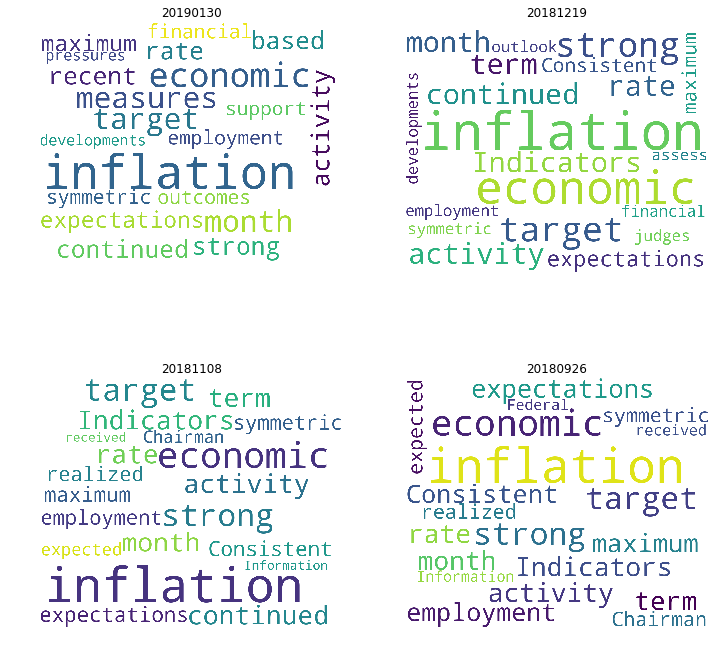

In [751]:

texts = [result[0],result[8],result[7],result[6]]
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
#Remove unwanted words
#As we look at the cloud, we can get rid of words that don't make sense by adding them to this variable
DELETE_WORDS = ['Committee','federal','range','labor','market','inflation'
                'economic','information','funds','percent','conditions','objective']
def remove_words(text_string,DELETE_WORDS=DELETE_WORDS):
    for word in DELETE_WORDS:
        text_string = text_string.replace(word,' ')
    return text_string
#Remove short words
MIN_LENGTH = 5
def remove_short_words(text_string,min_length = MIN_LENGTH):
    word_list = text_string.split()
    for word in word_list:
        if len(word) < min_length:
            text_string = text_string.replace(' '+word+' ',' ',1)
    return text_string


#Set up side by side clouds
COL_NUM = 2
ROW_NUM = 2
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))
for i in range(0,len(texts)):
    text_string = remove_words(texts[i][1])
    text_string = remove_short_words(text_string)
    ax = axes[i//2, i%2] 
    ax.set_title(texts[i][0])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,height=1000,
                          max_words=20).generate(text_string)
    ax.imshow(wordcloud)
    ax.axis('off')
plt.show()

### 2. Dispersion over time
<li>Dispersion plots show the relative frequency of words over the text,we could see how the frequency of some words has changed over the course of the FOMC. It should give us some idea of how the focus of FOMC has changed
<li>From the result below we could see words lik 'inflation','labor'are frequently appearing while word 'slow','pressure','diminish' appears in some specific year

In [753]:
import nltk
all_text = list()
for i in range(len(result)):
    all_text.append(result[i][1])

In [754]:
from nltk import sent_tokenize,word_tokenize 
tokens = nltk.word_tokenize(str(all_text))
text = nltk.Text(tokens)

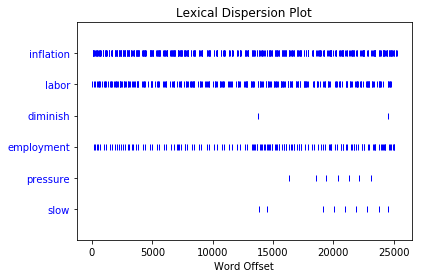

In [759]:
text.dispersion_plot(["inflation", "labor", "diminish", "employment",'pressure','slow'])

### 3. Taking all three method together, find the common 'negative' and 'positive' statement

In [321]:
positive = set(vader_pos)&set(pos_list)&set(pos_method2_list)
negative = set(neg_list)&set(neg_method2_list)

In [322]:
positive

{'20140319', '20140430', '20140618', '20140730', '20140917'}

In [323]:
negative

{'20141217', '20150128', '20150318'}

### 4. Word Frequency Stats

In [324]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from collections import OrderedDict
import pprint

In [327]:
lowercase_words = [token.lower() for token in tokens
                  if token not in stopwords.words() and token.isalpha()]

In [328]:
word_frequencies = FreqDist(lowercase_words)
most_frequent_words = word_frequencies.most_common(20)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(most_frequent_words)
# It returns the most commonly used words in the statement

[   ('committee', 552),
    ('inflation', 477),
    ('market', 286),
    ('labor', 259),
    ('rate', 250),
    ('economic', 248),
    ('federal', 236),
    ('percent', 221),
    ('conditions', 199),
    ('funds', 193),
    ('policy', 189),
    ('the', 186),
    ('range', 169),
    ('securities', 148),
    ('employment', 140),
    ('target', 133),
    ('maximum', 118),
    ('expected', 117),
    ('agency', 106),
    ('measures', 105)]


In [329]:
## Functionalize the summary function
def build_naive_summary(text):
    from nltk.tokenize import word_tokenize
    from nltk.tokenize import sent_tokenize
    from nltk.probability import FreqDist
    from nltk.corpus import stopwords
    from collections import OrderedDict
#candidate_sentences is a dictionary with the original sentence as the key, 
#and its lowercase version as the value
#summary_sentences is a list containing the sentences that will be included in the summary
#candidate_sentence_counts is a dictionary with the original sentence as the key, 
#and the sum of the frequencies of each word in the sentence as the value
    summary_sentences = []  
    candidate_sentences = {}
    candidate_sentence_counts = {}
    striptext = text.replace('\n\n', ' ')
    striptext = striptext.replace('\n', ' ')
    words = word_tokenize(striptext)
    lowercase_words = [word.lower() for word in words
                      if word not in stopwords.words() and word.isalpha()]
    word_frequencies = FreqDist(lowercase_words)
    most_frequent_words =word_frequencies.most_common(20)
    sentences = sent_tokenize(striptext)
    for sentence in sentences:
        candidate_sentences[sentence] = sentence.lower()
    for upper, lower in candidate_sentences.items():
        count = 0
        for freq_word, frequency_score in most_frequent_words:
            if freq_word in lower:
                count += frequency_score
                candidate_sentence_counts[upper] = count   
    sorted_sentences = OrderedDict(sorted(
                        candidate_sentence_counts.items(),
                        key = lambda x: x[1],
                        reverse = True)[:4])
    return sorted_sentences

In [332]:
summarize_sentence = list()
for i in range(len(result)):
    sorted_sentence = build_naive_summary(result[i][1])
    summarize_sentence.append((result[i][0],sorted_sentence))    

#### It returns the key sentences or topic sentences after weighting the words frequency given a FOMC statement

In [333]:
summarize_sentence

[('20190130',
  OrderedDict([('In light of global economic and financial developments and muted inflation pressures, the Committee will be patient as it determines what future adjustments to the target range for the federal funds rate may be appropriate to support these outcomes.In determining the timing and size of future adjustments to the target range for the federal funds rate, the Committee will assess realized and expected economic conditions relative to its maximum employment objective and its symmetric 2 percent inflation objective.',
                49),
               ("The Committee continues to view sustained expansion of economic activity, strong labor market conditions, and inflation near the Committee's symmetric 2 percent objective as the most likely outcomes.",
                41),
               ('Information received since the Federal Open Market Committee met in December indicates that the labor market has continued to strengthen and that economic activity has been 

## FOMC LDA analysis
<h4>tf-idf</h4>

<li>tf-idf: term frequency - inverse document frequency
<li>LDA increases the weight of words that occur frequently (tf)
<li>But reduces the weight of words that occur across many documents in the document set (idf)
<h4>Parameters:</h4>
    
<li>Number of topics: The number of topics you want generated. 
<li>Passes: The number of time the LDA model goes through the document. More passes, slower analysis
<ol>
<li>LDA first randomly assigns words and word weights to each topic
<li>In each pass, it refines the weights
<li>In short, you want the number of passes to be wherever the gain (improved weights) is minimal

In [348]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
import pprint

C:\Users\Quinntang\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [388]:
textsFOMC = [[word for word in text.lower().split()
        if word not in STOPWORDS and word.isalnum() and not word.lower() == 'slate']
        for text in all_text] #Here remove 2019 FOMC and want to use 2019 FOMC to test the LDA

In [389]:
dictionary = corpora.Dictionary(textsFOMC) #(word_id,frequency) pairs
corpus = [dictionary.doc2bow(text) for text in textsFOMC] #(word_id,freq) pairs by sentence
#dictionary[4]
#dictionary.keys()
dictionary.token2id

{'2': 0,
 '2019': 1,
 'account': 2,
 'action': 3,
 'activity': 4,
 'adjustments': 5,
 'appropriate': 6,
 'assess': 7,
 'assessment': 8,
 'business': 9,
 'charles': 10,
 'committee': 11,
 'compensation': 12,
 'conditions': 13,
 'continued': 14,
 'continues': 15,
 'december': 16,
 'decided': 17,
 'determines': 18,
 'determining': 19,
 'developments': 20,
 'earlier': 21,
 'economic': 22,
 'employment': 23,
 'energy': 24,
 'eric': 25,
 'esther': 26,
 'expansion': 27,
 'expectations': 28,
 'expected': 29,
 'federal': 30,
 'financial': 31,
 'fixed': 32,
 'fomc': 33,
 'food': 34,
 'foster': 35,
 'funds': 36,
 'future': 37,
 'gains': 38,
 'global': 39,
 'grow': 40,
 'growth': 41,
 'household': 42,
 'including': 43,
 'indicates': 44,
 'indicators': 45,
 'inflation': 46,
 'information': 47,
 'international': 48,
 'investment': 49,
 'issued': 50,
 'items': 51,
 'james': 52,
 'january': 53,
 'jerome': 54,
 'job': 55,
 'john': 56,
 'labor': 57,
 'lael': 58,
 'light': 59,
 'likely': 60,
 'little': 6

## Implement LDA

In [417]:
import warnings
warnings.filterwarnings('ignore')

In [418]:
#Set parameters
num_topics = 5 #The number of topics that should be generated
passes = 10

In [419]:
lda = LdaModel(corpus,id2word=dictionary,num_topics=num_topics,passes=passes)

In [420]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(lda.print_topics(num_words=8))

[   (   0,
        '0.045*"committee" + 0.036*"inflation" + 0.024*"market" + '
        '0.024*"labor" + 0.019*"federal" + 0.018*"economic" + '
        '0.017*"securities" + 0.015*"funds"'),
    (   1,
        '0.040*"inflation" + 0.032*"committee" + 0.028*"federal" + '
        '0.028*"economic" + 0.025*"market" + 0.024*"funds" + 0.021*"labor" + '
        '0.021*"2"'),
    (   2,
        '0.007*"inflation" + 0.006*"committee" + 0.005*"market" + '
        '0.004*"employment" + 0.004*"federal" + 0.004*"2" + 0.004*"rate" + '
        '0.003*"policy"'),
    (   3,
        '0.044*"committee" + 0.033*"inflation" + 0.024*"market" + '
        '0.023*"labor" + 0.019*"securities" + 0.018*"economic" + '
        '0.017*"policy" + 0.015*"employment"'),
    (   4,
        '0.003*"committee" + 0.003*"market" + 0.002*"inflation" + '
        '0.002*"federal" + 0.002*"rate" + 0.002*"securities" + 0.002*"labor" + '
        '0.002*"economic"')]


In [766]:
#Draw wordclouds weighted by the weight of the terms in the topic
def draw_wordcloud(lda,topicnum,min_size=0,STOPWORDS=['committee','federal','price','rate','market','inflation','labor','economic']):#stopwords can be changed
    word_list=[]
    prob_total = 0
    for word,prob in lda.show_topic(topicnum,topn=50):
        prob_total +=prob
    for word,prob in lda.show_topic(topicnum,topn=50):
        if word in STOPWORDS or  len(word) < min_size:
            continue
        freq = int(prob/prob_total*1000)
        alist=[word]
        word_list.extend(alist*freq)

    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt
    %matplotlib inline
    text = ' '.join(word_list)
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',
                          max_words=20, collocations=False).generate(text)
    plt.axis('off')
    plt.imshow(wordcloud,interpolation='bilinear')
    return None

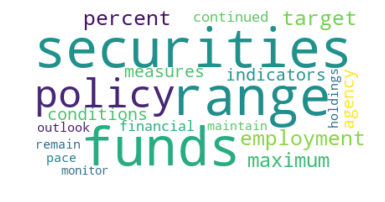

In [767]:
draw_wordcloud(lda,4)

## Understand LDA analysis for FOMC statement

In [423]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

# Visulaize the trend of the sentimental Analysis

In [470]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

In [431]:
#Resort the dataframe as time series
nrc_df.index = pd.to_datetime(nrc_df.index)
nrc_df = nrc_df.sort_index()

In [435]:
method_2.index = pd.to_datetime(method_2.index)
method_2 = method_2.sort_index()

In [438]:
vader_df = vader_comparison(result)
vader_df.index = pd.to_datetime(vader_df.index)
vader_df = vader_df.sort_index()

In [447]:
nrc_neg_trend = np.array(nrc_df.Neg_Score)
nrc_pos_trend = np.array(nrc_df.Pos_Score)

In [448]:
huliu_pos_trend = np.array(method_2.Positive_Proportion)
huliu_neg_trend = np.array(method_2.Negative_Proportion)

In [450]:
vader_pos_trend = np.array(vader_df.Positive)
vader_neg_trend = np.array(vader_df.Negative)

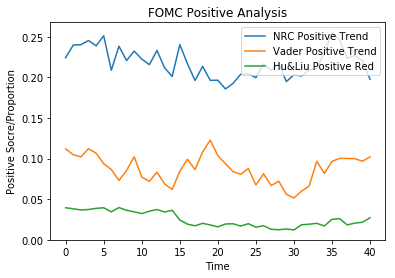

In [517]:
dates = list(nrc_df.index)
plt.plot(nrc_pos_trend,label='NRC Positive Trend')
plt.plot(vader_pos_trend,label='Vader Positive Trend')
plt.plot(huliu_pos_trend,label='Hu&Liu Positive Red')
plt.xlabel('Time')
plt.ylabel('Positive Socre/Proportion')
plt.title("FOMC Positive Analysis")
plt.legend(loc='upper right')

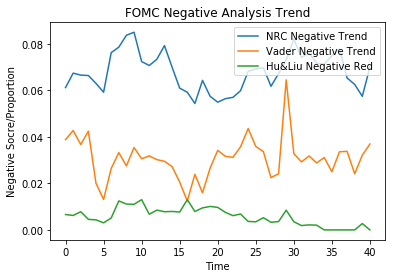

In [768]:
plt.plot(nrc_neg_trend,label='NRC Negative Trend')
plt.plot(vader_neg_trend,label='Vader Negative Trend')
plt.plot(huliu_neg_trend,label='Hu&Liu Negative Red')
plt.xlabel('Time')
plt.ylabel('Negative Socre/Proportion')
plt.title("FOMC Negative Analysis Trend")
plt.legend(loc='upper right')

## Try to find out the impact of FOMC sentimental results to 10yrs T-notes

In [526]:
from pandas_datareader import data as web
import datetime
start=datetime.datetime(2014, 1, 29)
end=datetime.datetime(2019,1,30)

In [528]:
tnx = web.DataReader(['^TNX'],'yahoo', start, end)

Text(0.5,1,'10-Year Treasury Notes')

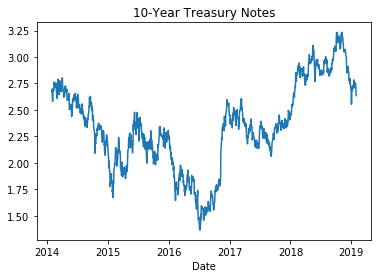

In [530]:
plt.plot(tnx['Close'])
plt.xlabel('Date')
plt.title("10-Year Treasury Notes")

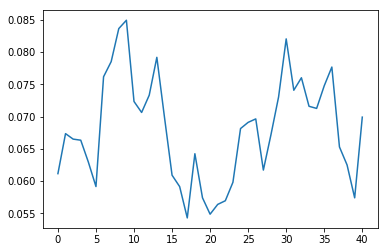

In [728]:
plt.plot(nrc_neg_trend)

## Here, I focous on the volatility change of 10yrs T-note
### Mark the Volatility Change, +1 means σt+1 > σt, else -1 if σt+1 < σt

In [602]:
# Do 30-days moving average
tnx_rolling_std = tnx.rolling(window=30).std()
tnx_rolling_std = tnx_rolling_std.dropna()
tnx_rolling_std = tnx_rolling_std['Close'].pct_change()
tnx_rolling_std = tnx_rolling_std.dropna()

In [603]:
#Mark the Volatility Change, +1 means σt+1 > σt, else -1 if σt+1 < σt
tnx_rolling_std['Vol_Change'] = np.where(tnx_rolling_std['^TNX']>0,1,-1)

In [605]:
#Calculate the average valotatility during the time span between the announcement of two FOMC Statement
tnx_rolling_std_FOMC = np.array([])
for i in range(0,len(dates)-1):
        tnx_rolling_std_FOMC = np.append(tnx_rolling_std_FOMC,tnx_rolling_std.loc[dates[i]:dates[i+1]]['Vol_Change'].mean())

In [612]:
tnx_rolling_std_FOMC = np.where(tnx_rolling_std_FOMC>0,1,-1)

In [619]:
nrc_df.index = pd.to_datetime(nrc_df.index)
nrc_df = nrc_df.sort_index()

In [621]:
#Drop the FOMC statement on 2019/1/30 since it cannot be properly indicated the trend
nrc_df = nrc_df[:-1]

In [632]:
nrc_df['Vol_Change'] = tnx_rolling_std_FOMC

## Implement Logistic Regression with Cross-Validation
### Using the NRC Sentimental Score

<li>cv : integer or cross-validation generator, default: None.The default cross-validation generator used is Stratified K-Folds.
<li>penalty : str,‘L1’ or ‘L2'.Used to specify the norm used in the penalization. The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties.

In [769]:
## Times Series, the order matters
from sklearn.model_selection import train_test_split
# train, test = train_test_split(nrc_df, test_size = 0.3)
train = nrc_df.iloc[0:29]
test = nrc_df.iloc[29:]
x_train = train[['Neg_Score']]
y_train = train[['Vol_Change']]
x_test = test[['Neg_Score']]
y_test = test[['Vol_Change']]

In [734]:
from sklearn.linear_model import LogisticRegressionCV

In [770]:
logCV = LogisticRegressionCV(cv=5, random_state=0).fit(x_train,y_train)

In [771]:
log_train = logCV.predict(x_train)
log_test = logCV.predict(x_test)

In [772]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, log_test))  
print(classification_report(y_test, log_test))  

[[2 3]
 [1 5]]
             precision    recall  f1-score   support

         -1       0.67      0.40      0.50         5
          1       0.62      0.83      0.71         6

avg / total       0.64      0.64      0.62        11



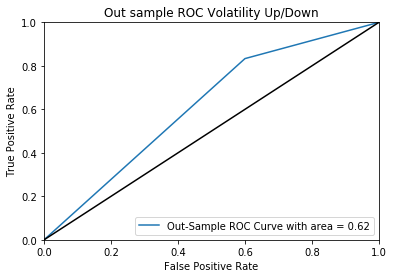

In [773]:
# Drwa the ROC curve (Receiver Operating Characteristics). It tells how much model is capable of distinguishing between classes. 
from sklearn.metrics import roc_curve,auc
import pylab as pl
%matplotlib inline
(fpr, tpr, thresholds) = roc_curve(y_test,log_test)
area = auc(fpr,tpr)
pl.clf() #Clear the current figure
pl.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area)

pl.plot([0, 1], [0, 1], 'k') #This plots the random (equal probability line)
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Out sample ROC Volatility Up/Down')
pl.legend(loc="lower right")
pl.show()

## Implement Kernel SVM
### SVM is suitable when data sample is small
<li>C : float, optional (default=1.0),Penalty parameter C of the error term.
<li>gamma : float, optional (default=’auto’).Kernel coefficient
<li>kernel : string, optional (default=’rbf’)

In [729]:
from sklearn.svm import SVC
svc = SVC(kernel='linear').fit(x_train, y_train)

In [730]:
svc_train = svc.predict(x_train)
svc_test = svc.predict(x_test)

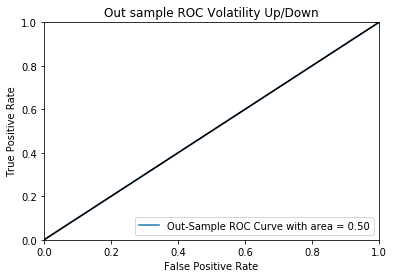

In [739]:
(fpr, tpr, thresholds) = roc_curve(y_test,svc_test)
area = auc(fpr,tpr)
pl.clf() #Clear the current figure
pl.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area)
pl.plot([0, 1], [0, 1], 'k') #This plots the random (equal probability line)
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Out sample ROC Volatility Up/Down')
pl.legend(loc="lower right")
pl.show()
# The result is not good compared with logistic regression CV method

## Implement Random forest
### !may cause overfitting given there is only two classes as output (Volatility goes up/down)

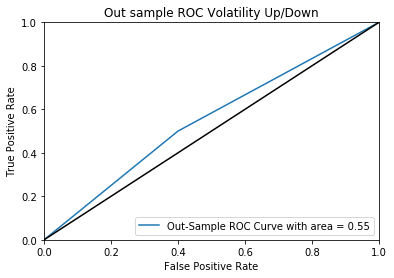

In [741]:
from sklearn.ensemble import RandomForestClassifier

clfRF = RandomForestClassifier(n_estimators=10)
clfRF.fit(x_train,np.ravel(y_train))
clf_pred = clfRF.predict(x_test)
cfm = confusion_matrix(np.ravel(y_test),clf_pred)
(fpr, tpr, thresholds) = roc_curve(y_test,clf_pred)
area = auc(fpr,tpr)
pl.clf() #Clear the current figure
pl.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area)
pl.plot([0, 1], [0, 1], 'k') #This plots the random (equal probability line)
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Out sample ROC Volatility Up/Down')
pl.legend(loc="lower right")
pl.show()